# LCLS cu_hxr from archived data

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from lcls_live.datamaps import get_datamaps
from lcls_live.archiver import lcls_archiver_restore

import os

In [4]:
BEAMPATH = 'cu_hxr'

## Datamaps, and all PVs needed

In [5]:
DM = get_datamaps(BEAMPATH)

DM.keys()

dict_keys(['collimators', 'subboosters', 'linac', 'K21_1', 'K21_2', 'K21_3', 'K21_4', 'K21_5', 'K21_6', 'K21_7', 'K21_8', 'K22_1', 'K22_2', 'K22_3', 'K22_4', 'K22_5', 'K22_6', 'K22_7', 'K22_8', 'K23_1', 'K23_2', 'K23_3', 'K23_4', 'K23_5', 'K23_6', 'K23_7', 'K23_8', 'K24_1', 'K24_2', 'K24_3', 'K24_4', 'K24_5', 'K24_6', 'K25_1', 'K25_2', 'K25_3', 'K25_4', 'K25_5', 'K25_6', 'K25_7', 'K25_8', 'K26_1', 'K26_2', 'K26_3', 'K26_4', 'K26_5', 'K26_6', 'K26_7', 'K26_8', 'K27_1', 'K27_2', 'K27_3', 'K27_4', 'K27_5', 'K27_6', 'K27_7', 'K27_8', 'K28_1', 'K28_2', 'K28_3', 'K28_4', 'K28_5', 'K28_6', 'K28_7', 'K28_8', 'K29_1', 'K29_2', 'K29_3', 'K29_4', 'K29_5', 'K29_6', 'K29_7', 'K29_8', 'K30_1', 'K30_2', 'K30_3', 'K30_4', 'K30_5', 'K30_6', 'K30_7', 'K30_8', 'quad', 'beginning_WS02', 'tao_energy_measurements'])

In [6]:
# datamaps to exclude
DENYLIST = ['beginning_WS02', 'quad']

In [7]:
# PVs needed
ALLPVS =  []
for name, dm in DM.items():
    if name in DENYLIST:
        continue
    ALLPVS.extend(dm.pvlist)
ALLPVS = list(set(ALLPVS))
len(ALLPVS)

554

## Archiver restore

In [8]:
ISOTIME = '2021-04-21T08:10:25.000000-07:00'

In [9]:
os.environ['http_proxy']='socks5h://localhost:8080'
os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
os.environ['ALL_PROXY']='socks5h://localhost:8080'

In [10]:
PVDATA = lcls_archiver_restore(ALLPVS, ISOTIME)

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2021-04-21T08:10:25.000000-07:00&includeProxies=true


## Form commands using PVDATA and datamaps

In [11]:
CMDS = []
for name, dm in DM.items():
    CMDS.extend(dm.as_tao(PVDATA))

CMDS[0:5]

['set ele CE11 x1_limit = -0.001 * -4.427071416715884',
 'set ele CE11 x2_limit = 0.001 * 2.6004898727889953',
 'set ele SBST_21 phase_deg = 0.1586761474609375',
 'set ele SBST_22 phase_deg = -0.38561248779296875',
 'set ele SBST_23 phase_deg = -0.07339859008789062']

# Start Tao

In [12]:
from pytao import Tao

In [13]:
tao = Tao(f'-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice BEGINNING:END -noplot')

In [14]:
# apply commands all at once
tao.cmds(CMDS);

In [15]:
# Explicitly save beam 
tao.cmd('set beam saved_at = MARKER::*')
#tao.cmd('set beam saved_at = BEGUNDH,ENDUNDH')

[]

In [16]:
# Turn on CSR
#tao.cmd(f'call $LCLS_LATTICE/bmad/models/{BEAMPATH}/scripts/Activate_CSR.tao');

In [17]:
# Turn on the beam
tao.cmd('set beam_init n_particle = 1000')

[]

In [18]:

#toggle on and off
tao.cmd('set global track_type = beam') 


['153 particle(s) lost at element 262: CE11  Total lost: 153  of 1000',
 'Total number of lost particles by the end of universe  1:   153.']

In [19]:
tao.cmd('set global track_type = single') 

[]

## Get particles 

In [20]:
from pmd_beamphysics import ParticleGroup

In [21]:
P = ParticleGroup(data=tao.bunch_data('ENDUNDH'))
# Select out live particles
P = P[P.status==1]

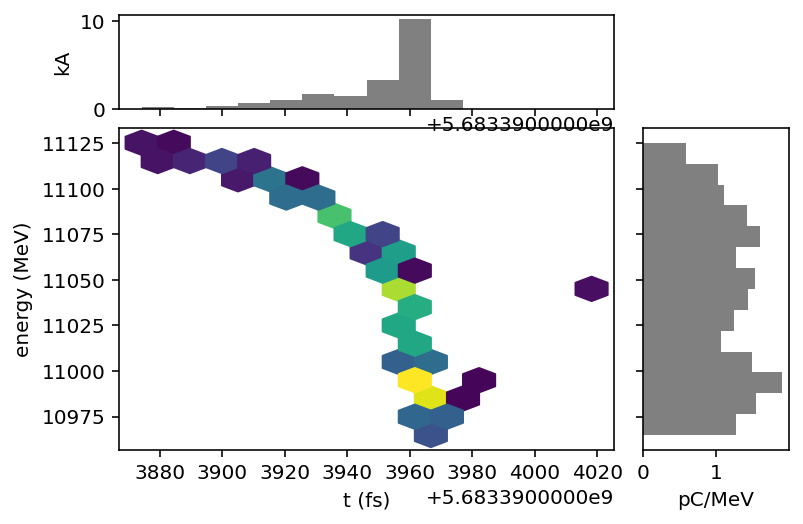

In [22]:
P.plot('t', 'energy')

In [23]:
# Make a functoion for this
def get_beam(ele):
    P = ParticleGroup(data=tao.bunch_data(ele))
    # Select out live particles
    P = P[P.status==1]    
    
    return P

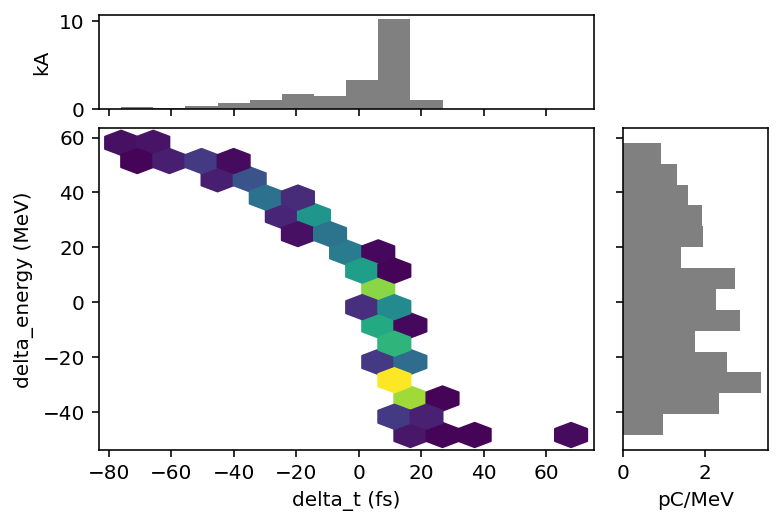

In [24]:
P1 = get_beam('BEGUNDH')
P1.plot('delta_t', 'delta_energy')

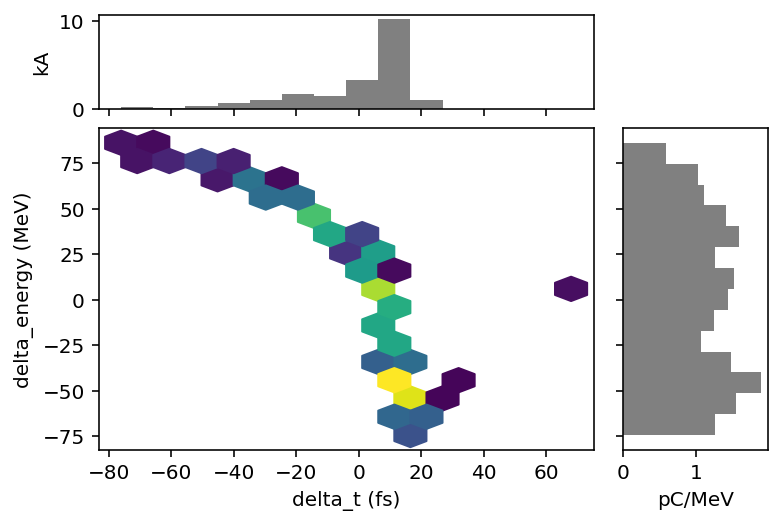

In [25]:
P2 = get_beam('ENDUNDH')
P2.plot('delta_t', 'delta_energy')

Text(0, 0.5, 'delta_energy (eV)')

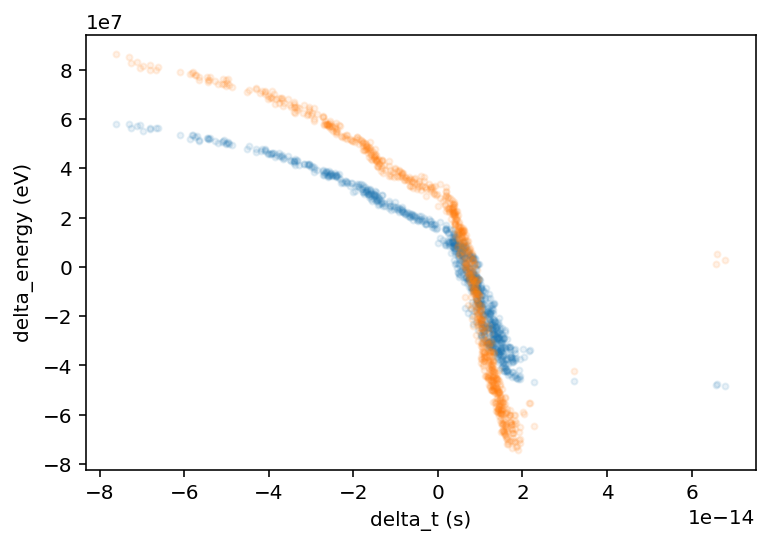

In [26]:
# Compare on the same plot
k1= 'delta_t'
k2 = 'delta_energy'
plt.scatter(P1[k1], P1[k2], marker='.', alpha=0.1)
plt.scatter(P2[k1], P2[k2], marker='.', alpha=0.1)
plt.xlabel(f'{k1} ({P1.units(k1).unitSymbol})')
plt.ylabel(f'{k2} ({P1.units(k2).unitSymbol})')

# Get giant table of bunch stats

In [27]:
import pandas as pd

In [28]:
# Get list of indices
IX = tao.lat_list('*', 'ele.ix_ele')

# Stop before the dump
S_STOP = tao.ele_head('ENDUNDH')['s']

stats = []
for ele in IX:
    d = tao.bunch_params(ele)
    # Skipl ones with no beam
    if d['charge_live'] == 0:
        continue
    
    if d['s'] > S_STOP:
        break
        
    stats.append(d)

df = pd.DataFrame(stats)#.set_index('ix_ele')
df

,beta_x,alpha_x,gamma_x,phi_x,eta_x,etap_x,sigma_x,sigma_p_x,emit_x,norm_emit_x,...,ix_ele,direction,species,location,s,charge_live,n_particle_tot,n_particle_live,n_particle_lost_in_ele,beam_saved
0,1.164140,0.082869,0.864902,0.0,0.002112,0.004866,0.000045,0.000039,1.721187e-09,4.547255e-07,...,148,1,Electron,Downstream_End,14.241029,2.500000e-10,1000,1000,0,True
1,1.160237,-0.058918,0.864885,0.0,0.002911,0.004866,0.000045,0.000039,1.721222e-09,4.547348e-07,...,149,1,Electron,Downstream_End,14.404860,2.500000e-10,1000,1000,0,False
2,1.160237,-0.058918,0.864885,0.0,0.002911,0.004866,0.000045,0.000039,1.721222e-09,4.547348e-07,...,150,1,Electron,Downstream_End,14.404860,2.500000e-10,1000,1000,0,False
3,3.559600,-1.441537,0.864712,0.0,0.010699,0.004866,0.000078,0.000039,1.721566e-09,4.548257e-07,...,151,1,Electron,Downstream_End,16.002790,2.500000e-10,1000,1000,0,False
4,3.559600,-1.441537,0.864712,0.0,0.010699,0.004866,0.000078,0.000039,1.721566e-09,4.548257e-07,...,152,1,Electron,Downstream_End,16.002790,2.500000e-10,1000,1000,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,187.452559,-6.484018,0.229618,0.0,0.001028,0.000036,0.000060,0.000002,1.936432e-11,4.183285e-07,...,2903,1,Electron,Downstream_End,1703.774965,2.117500e-10,1000,847,0,False
2756,188.192985,-6.497076,0.229615,0.0,0.001030,0.000036,0.000060,0.000002,1.936454e-11,4.183334e-07,...,2904,1,Electron,Downstream_End,1703.831965,2.117500e-10,1000,847,0,False
2757,188.192985,-6.497076,0.229615,0.0,0.001030,0.000036,0.000060,0.000002,1.936454e-11,4.183334e-07,...,2905,1,Electron,Downstream_End,1703.831965,2.117500e-10,1000,847,0,True
2758,188.192985,-6.497076,0.229615,0.0,0.001030,0.000036,0.000060,0.000002,1.936454e-11,4.183334e-07,...,2906,1,Electron,Downstream_End,1703.831965,2.117500e-10,1000,847,0,True


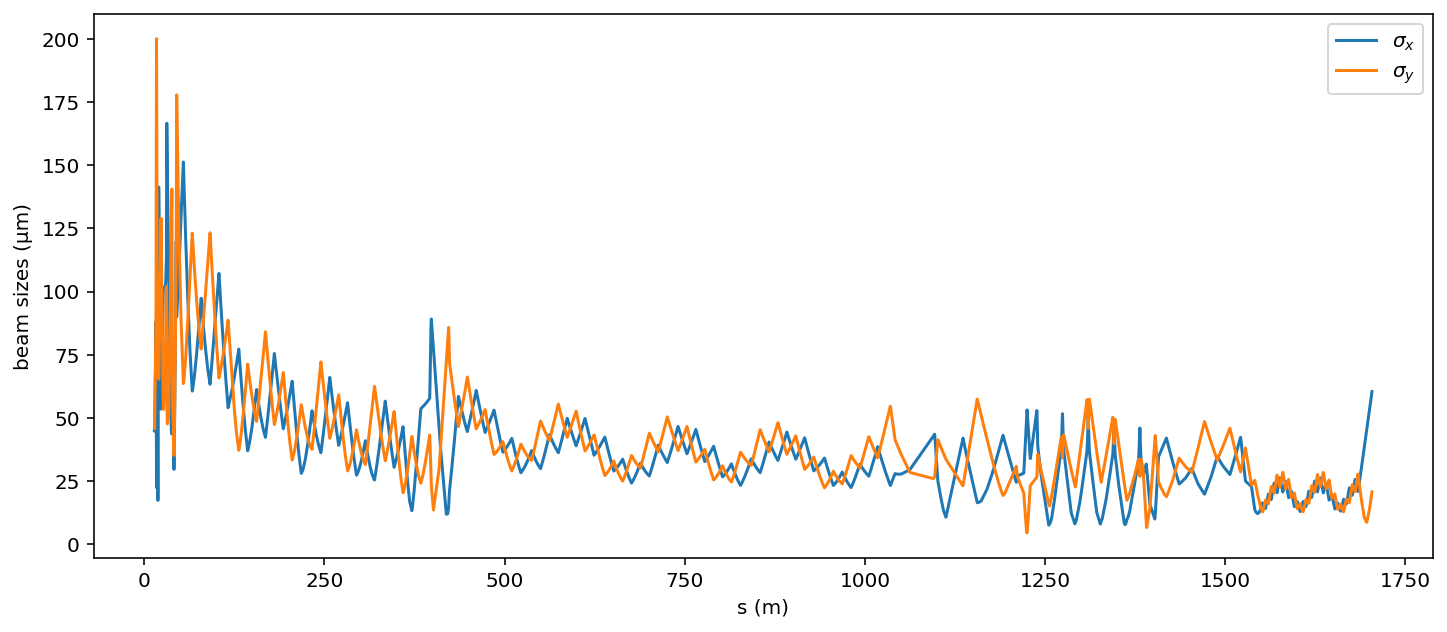

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['sigma_x']*1e6, label=r'$\sigma_x$')
plt.plot(df['s'], df['sigma_y']*1e6, label=r'$\sigma_y$')
plt.xlabel('s (m)')
plt.ylabel('beam sizes (µm)')
plt.legend();

In [30]:
# Get an array of where the beam is saved
s_saved = np.array(df[df['beam_saved']]['s'])

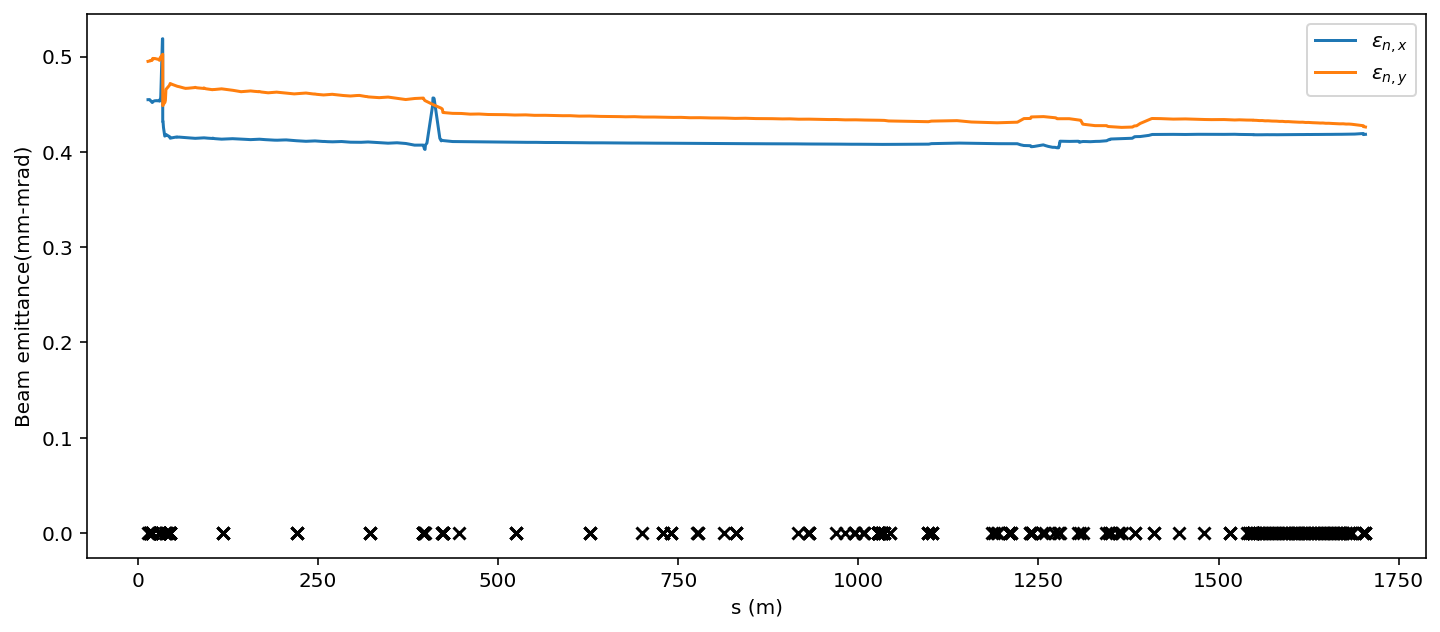

In [31]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['s'], df['norm_emit_x']*1e6, label=r'$\epsilon_{n,x}$')
plt.plot(df['s'], df['norm_emit_y']*1e6, label=r'$\epsilon_{n,y}$')
plt.xlabel('s (m)')
plt.ylabel('Beam emittance(mm-mrad)')


# This is where the beam is saved
plt.scatter(s_saved, np.ones(len(s_saved))*0, color = 'black', marker = 'x')


plt.legend();